#### Global & Local Modules

In [1]:
import os
from itertools import permutations 
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from tqdm import tqdm
from keras.layers import Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from rgcn import GaussianGraphConvolution, kl_reg

Using TensorFlow backend.


In [2]:
%matplotlib inline

#### Vendor Modules

In [3]:
# the path of execution
EXE_PATH = os.path.abspath(os.path.curdir)
# the path of the vendor files
VENDOR_PATH = os.path.join(EXE_PATH, 'vendor')
# the vendors to include in the system path
VENDORS = ['keras-gcn']
# create the absolute paths for all vendors
VENDORS = list(map(lambda x: os.path.join(VENDOR_PATH, x), VENDORS))
# update the Python path to include necessary vendor module
sys.path += VENDORS
# import vendor modules
from kegra.layers.graph import GraphConvolution
from kegra.utils import load_data, preprocess_adj, get_splits, evaluate_preds

# Data

In [4]:
def attack_edges(attack_ratio: float) -> 'callable':
    """
    Create an edge attack function with given attack ratio.

    Args:
        attack_ratio: the ratio of noise to clean edges

    Returns:
        a callable function for attacking a graph

    """
    def _attack_edges(edges: np.ndarray) -> np.ndarray:
        f"""
        Attack the edges of the given list of edges.

        Args:
            edges: the ndarray of tuples representing edges to attack

        Returns:
            a new ndarray of edges with random edges added

        Note:
            the ratio of noise to clean edges is {attack_ratio}

        """
        # create the set of all possible edges
        all_edges = set(permutations(list(range(edges.max())), 2))
        # convert the ndarray of edges to a set of tuples
        edges = set(map(tuple, edges))
        # create the set of edges to sample by subtracting the existing
        # edges from the set of possible edges
        sample_edges = all_edges - edges
        # select random edges without replacement based on the noise ratio
        attack_edges = np.random.choice(list(range(len(sample_edges))), 
            size=int(len(edges) * attack_ratio), 
            replace=False)
        attack_edges = [edge for (i, edge) in enumerate(list(sample_edges)) if i in attack_edges]
        # create the new ndarray of edges with the attack edges added
        edges = list(edges) + attack_edges
        return np.array(edges)
    return _attack_edges

In [5]:
def run(attack_ratio) -> tuple:
    """
    Perform an experimental run with given attack ratio.

    Args:
        attack_ratio: the ratio of noise to clean edges

    Returns:
        a tuple of GCN and RGCN accuracies

    """
    # load the input data
    X, A, y = load_data('data/cora/', dataset='cora', attack_edges=attack_edges(attack_ratio))
    X /= X.sum(1).reshape(-1, 1)
    A = preprocess_adj(A)
    y_train, y_val, y_test, idx_train, idx_val, idx_test, train_mask = get_splits(y)
    # create the input layers
    X_in = Input(shape=(X.shape[1], ), name='features')
    A_in = Input(shape=(None, None), batch_shape=(None, None), sparse=True, name='graph')
    # create the training loop
    def train(model, epochs=200, patience=10):
        """
        Train the given model.

        Args:
            model: the model to train
            epochs: the maximum number of training epochs
            patience: the number of patience epochs for early stoping

        Returns:
            a tuple of the testing loss and accuracy

        """
        wait = 0
        preds = None
        best_val_loss = 99999
        # Fit
        for epoch in range(1, epochs + 1):
            # Single training iteration (we mask nodes without labels for loss calculation)
            model.fit([X, A], y_train, 
                sample_weight=train_mask,
                batch_size=A.shape[0], 
                epochs=1, 
                shuffle=False, 
                verbose=0)
            # Predict on full dataset
            preds = model.predict([X, A], batch_size=A.shape[0])
            # Train / validation scores
            train_val_loss, train_val_acc = evaluate_preds(preds, [y_train, y_val], [idx_train, idx_val])
            # Early stopping
            if train_val_loss[1] < best_val_loss:  # better loss than best
                best_val_loss = train_val_loss[1]
                wait = 0
            elif wait >= patience:  # early stopping
                break
            else:  # waiting for better loss
                wait += 1
        # return test set evaluation metrics
        return evaluate_preds(preds, [y_test], [idx_test])

    # GCN
    H = Dropout(0.5)(X_in)
    H = GraphConvolution(32, 1, 
        activation='relu', 
        kernel_regularizer=l2(5e-4)
    )([H, A_in])
    H = Dropout(0.5)(H)
    Y = GraphConvolution(y.shape[1], 1, 
        activation='softmax'
    )([H, A_in])
    gcn = Model(inputs=[X_in, A_in], outputs=Y)
    gcn.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['acc'])
    gcn_acc = train(gcn)[1]

    # RGCN
    H = Dropout(0.6)(X_in)
    M1, S1 = GaussianGraphConvolution(16,
        is_first=True,
        dropout=0.6
    )([H, A_in])
    Y = GaussianGraphConvolution(y.shape[1],
        is_last=True,
        last_activation='softmax',
    )([M1, S1, A_in])
    rgcn = Model(inputs=[X_in, A_in], outputs=Y)
    rgcn.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01))
    rgcn.add_loss(kl_reg(M1, S1, 5e-4), [M1, S1])
    rgcn_acc = train(rgcn)[1]
    
    return gcn_acc[0], rgcn_acc[0]

In [6]:
ratios = list(map(lambda x: x / 10 if x > 0 else 0, range(0, 11)))
ratios

[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [7]:
results = list(map(run, tqdm(ratios)))

  0%|          | 0/11 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W1120 16:01:29.566915 140245625362240 deprecation_wrapper.py:119] From /home/bitcommander/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1120 16:01:29.574364 140245625362240 deprecation_wrapper.py:119] From /home/bitcommander/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:515: The name tf.sparse_placeholder is deprecated. Please use tf.compat.v1.sparse_placeholder instead.

W1120 16:01:29.576231 140245625362240 deprecation_wrapper.py:119] From /home/bitcommander/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1120 16:01:29.576932 140245625362240 deprecation_wrapper.py:119] From /home/bitcommander/.local/lib/python3.7/site-packages/keras/

In [8]:
df = pd.DataFrame(results, columns=['GCN', 'RGCN'], index=ratios)
df.index.name = 'Noise Edge Ratio'
df

,GCN,RGCN
Noise Edge Ratio,,
0.0,0.803,0.786
0.1,0.775,0.760
0.2,0.753,0.753
0.3,0.702,0.698
0.4,0.693,0.711
0.5,0.661,0.661
0.6,0.594,0.628
0.7,0.644,0.653
0.8,0.587,0.610


In [13]:
!mkdir -p img

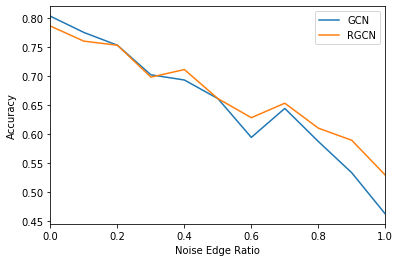

In [14]:
ax = df.plot()
ax.set_ylabel('Accuracy')
plt.savefig('img/plot.png')
plt.savefig('img/plot.pdf')